In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

data = pd.read_csv('data/data.csv', index_col=None)
data

,level,long,lat
0,0,-0.130495,51.511534
1,0,-0.140844,51.514684
2,0,-0.135874,51.515684
3,0,-0.110329,51.518250
4,0,-0.125708,51.507725
...,...,...,...
8953,1,-0.134599,51.511608
8954,1,-0.125331,51.513753
8955,1,-0.131706,51.509404
8956,1,-0.147526,51.516597


In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


scaler = MinMaxScaler()
X = scaler.fit_transform(data.loc[:, ['long', 'lat']])
Y = scaler.fit_transform(data.loc[:, ['level']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

In [62]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperParameters

from keras_tuner.tuners import BayesianOptimization


def build_model(hp):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size', values=[2, 3]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'LeakyReLU']),
        input_shape=(X_train.shape[1], 1),
        padding='same'))
        
    model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
    
    model.add(tf.keras.layers.Dense(2))
    model.add(tf.keras.layers.Dense(2))

    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='adam', loss='mse')
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss', 
    max_trials=15,     
    executions_per_trial=10,
    directory='new_keras_optimise_logs', 
    project_name='keras_tuning'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Trial 30 Complete [00h 00m 41s]
val_loss: 0.14488702416419982

Best val_loss So Far: 0.144815132021904
Total elapsed time: 00h 31m 23s


In [63]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test))

best_model.evaluate(X_test, Y_test)

Epoch 1/50
224/224 [==============================] - 0s 827us/step - loss: 0.1730 - val_loss: 0.1500
Epoch 2/50
224/224 [==============================] - 0s 589us/step - loss: 0.1477 - val_loss: 0.1490
Epoch 3/50
224/224 [==============================] - 0s 595us/step - loss: 0.1462 - val_loss: 0.1465
Epoch 4/50
224/224 [==============================] - 0s 723us/step - loss: 0.1454 - val_loss: 0.1468
Epoch 5/50
224/224 [==============================] - 0s 708us/step - loss: 0.1448 - val_loss: 0.1480
Epoch 6/50
224/224 [==============================] - 0s 592us/step - loss: 0.1449 - val_loss: 0.1462
Epoch 7/50
224/224 [==============================] - 0s 605us/step - loss: 0.1450 - val_loss: 0.1456
Epoch 8/50
224/224 [==============================] - 0s 715us/step - loss: 0.1443 - val_loss: 0.1456
Epoch 9/50
224/224 [==============================] - 0s 598us/step - loss: 0.1444 - val_loss: 0.1453
Epoch 10/50
224/224 [==============================] - 0s 594us/step - loss: 0.144

0.14442504942417145

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = best_model.predict(X_test)

56/56 [==============================] - 0s 367us/step


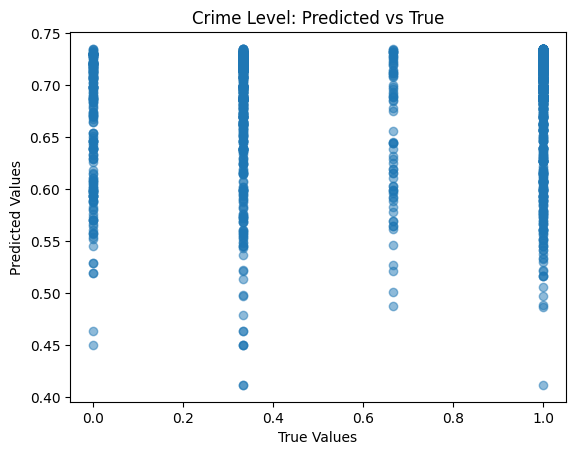

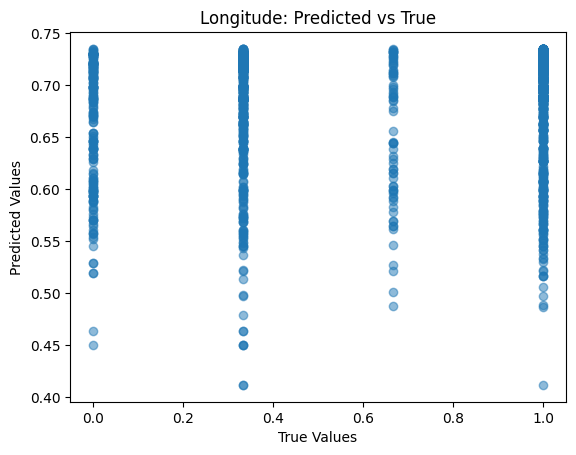

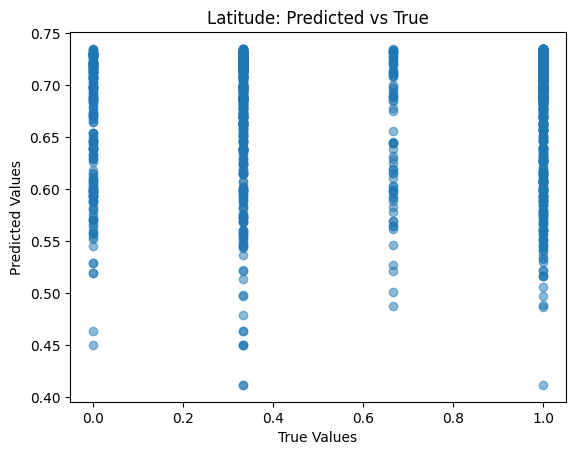

In [64]:
# Crime Level
plt.scatter(Y_test, predictions, alpha=0.5)
plt.title("Crime Level: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Longitude
plt.scatter(Y_test, predictions, alpha=0.5)
plt.title("Longitude: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Latitude
plt.scatter(Y_test, predictions, alpha=0.5)
plt.title("Latitude: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [65]:
mse_level = mean_squared_error(Y_test[0], predictions[0])
rmse_level = np.sqrt(mse_level)
mae_level = mean_absolute_error(Y_test[0], predictions[0])

print("Crime Level - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_level, rmse_level, mae_level))

Crime Level - MSE: 0.0814, RMSE: 0.2853, MAE: 0.2853
